# Bayesian Outlier Modeling 
## For N-of-1 Outlier Analysis of TCGA against Normal Sets

Model outliers using a linear combination of approximations. Each background dataset, $X_i$, for each gene $j$, contributes a posterior distribution of expression $y_{i,j}$ to a linear model that learns the vector of $\beta$ weights corresponding to each background comparison distribution to model an $n$-of-1 tumor sample's distribution $z_j$. Samples drawn from the posterior distribution $z_j$ are then compared to the n-of-1 sample.

# Inputs

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

import rnaseq_lib3 as r

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_hdf('/mnt/data/Objects/tcga_gtex_tpm_norm_filt.hd5')
df.head(2)

,id,tissue,subtype,tumor,label,RP11-40C6.2,IGHG1,IGKC,KRT5,IGLC2,...,IGHEP1,RP11-44N21.4,GAPDHP61,P2RX5-TAX1BP3,RP11-408H20.3,RP13-726E6.2,CTB-43E15.1,ZNF878,OR2H2,RP4-530I15.9
GTEX-UTHO-1226-SM-3GAEE,GTEX-UTHO-1226-SM-3GAEE,Heart,Heart_Atrial_Appendage,no,gtex,0.000000,10.302941,10.712460,2.750618,7.780669,...,0.000000,0.0,0.0,0.150556,0.0,0.000000,0.0,0.070387,0.790754,0.815589
GTEX-146FH-1726-SM-5QGQ2,GTEX-146FH-1726-SM-5QGQ2,Esophagus,Esophagus_Mucosa,no,gtex,2.970847,8.778885,10.445933,12.393268,8.440056,...,0.176318,0.0,0.0,0.411426,0.0,0.176318,0.0,0.622930,0.042644,0.378503


In [3]:
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]
len(drug_genes)

85

Subset by dataset

In [4]:
cols = df.columns[:5].tolist()
drug_df = df[cols + drug_genes]

gtex = df[df.label == 'gtex']
normal = df[df.label == 'tcga-normal']
tumor = df[df.label == 'tcga-tumor']

In [5]:
def plot_gene_dist(n_of_1, gene):
    plt.axvline(n_of_1[gene], label='n-of-1', color='red')
    sns.kdeplot(gtex[gene], label='gtex')
    sns.kdeplot(normal[gene], label='normal')
    sns.kdeplot(tumor[gene], label='tumor')    
    plt.title(gene);

# Build Model

In [7]:
def train_model(n_of_1, genes, datasets, n_samples=200, tune=1000):
    """
    n_of_1: tumor sample 
    genes: genes to learn
    datasets: datasets to include
    n_samples = Samples to generate
    """
    with pm.Model() as model:
        # Priors for gene expression
        hyper_shape = len(genes) * len(datasets)
        hyper_mu = pm.Normal('hyper_mu', 3, 3, shape=hyper_shape)
        hyper_sigma = pm.InverseGamma('hyper_sigma', 1, shape=hyper_shape)
        
        # RVs for Gene expression
        # X is observed and Y isn't, but they share hyper priors
        X, Y = {}, {}
        i = 0
        for gene in genes:
            for name, dataset in datasets:
                key = f'{gene}-{name}'
                X[key] = pm.Normal(f'X-{key}', mu=hyper_mu[i], sd=hyper_sigma[i], observed=dataset[gene])
                Y[key] = pm.Normal(f'Y-{key}', mu=hyper_mu[i], sd=hyper_sigma[i])
        i += 1
        
        # Priors for linear model
        alpha = pm.Normal('alpha', 0, 10)
        beta = pm.Normal('beta', 0, 5, shape=len(datasets))
        
        # Sigma prior for Z, shared across all genes
        sigma = pm.InverseGamma('sigma', 1)
        
        # Define linear model for each gene
        mu = {}
        for gene in genes:
            mu[gene] = alpha
            for j, (name, _) in enumerate(datasets):
                mu[gene] += Y[f'{gene}-{name}'] * beta[j]
        
        # Posterior distribution
        z = {}
        for i, gene in enumerate(genes):
            z[gene] = pm.Normal(gene, mu=mu[gene], sd=sigma, observed=n_of_1[gene])
        
        # Calculate trace
        trace = pm.sample(n_samples, 
                          tune=tune, 
                          nuts_kwargs={'target_accept': 0.95},
                          njobs=12)
    return model, trace

## Train

Select an n_of_1 sample and train

In [8]:
tumor_id = 'TCGA-KK-A7B2-01'

In [9]:
n_of_1 = tumor.loc[tumor_id]

Find an example gene that is not an outlier

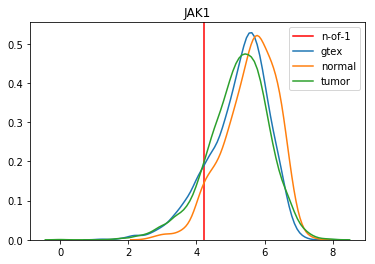

In [10]:
plot_gene_dist(n_of_1, gene='JAK1')

Find an example outlier gene

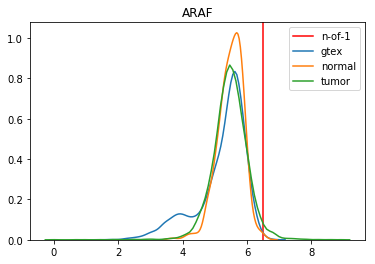

In [11]:
plot_gene_dist(n_of_1, gene='ARAF')

Train n-of-1 on drug genes

In [12]:
datasets = [('gtex', gtex), ('normal', normal)]
model, trace = train_model(n_of_1, drug_genes, datasets)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, beta, alpha, Y-PARP1-normal, Y-PARP1-gtex, Y-AURKC-normal, Y-AURKC-gtex, Y-AURKB-normal, Y-AURKB-gtex, Y-AURKA-normal, Y-AURKA-gtex, Y-MS4A1-normal, Y-MS4A1-gtex, Y-BTK-normal, Y-BTK-gtex, Y-HSP90B1-normal, Y-HSP90B1-gtex, Y-HSP90AB3P-normal, Y-HSP90AB3P-gtex, Y-HSP90AB1-normal, Y-HSP90AB1-gtex, Y-HSP90AA1-normal, Y-HSP90AA1-gtex, Y-MDM2-normal, Y-MDM2-gtex, Y-BCL6-normal, Y-BCL6-gtex, Y-BCL2-normal, Y-BCL2-gtex, Y-SMO-normal, Y-SMO-gtex, Y-GLI1-normal, Y-GLI1-gtex, Y-PTCH1-normal, Y-PTCH1-gtex, Y-MAP2K2-normal, Y-MAP2K2-gtex, Y-MAP2K1-normal, Y-MAP2K1-gtex, Y-ARAF-normal, Y-ARAF-gtex, Y-RAF1-normal, Y-RAF1-gtex, Y-BRAF-normal, Y-BRAF-gtex, Y-HRAS-normal, Y-HRAS-gtex, Y-KRAS-normal, Y-KRAS-gtex, Y-NRAS-normal, Y-NRAS-gtex, Y-DEPTOR-normal, Y-DEPTOR-gtex, Y-MLST8-normal, Y-MLST8-gtex, Y-RPTOR-normal, Y-RPTOR-gtex, Y-MTOR-normal

# Traceplot

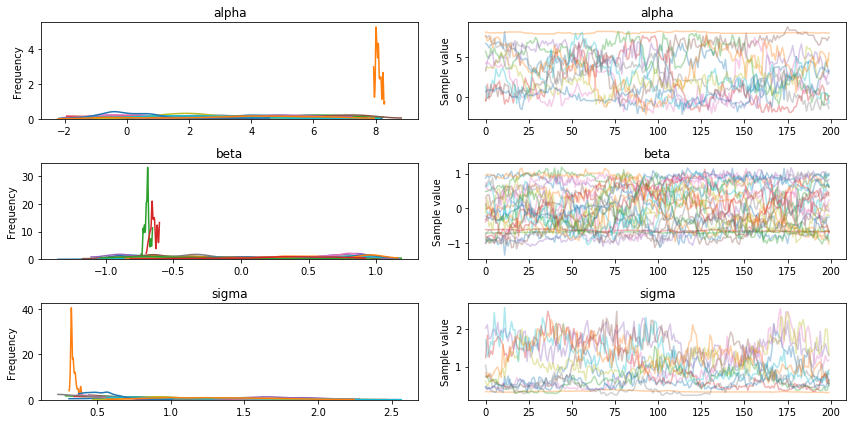

In [14]:
pm.traceplot(trace, varnames=['alpha', 'beta', 'sigma']);

Traceplots appear to have not converged.

## Parameter KDEs

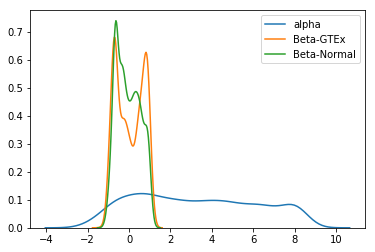

In [30]:
sns.kdeplot(trace['alpha'], label='alpha')
sns.kdeplot(trace['beta'][:,0], label='Beta-GTEx');
sns.kdeplot(trace['beta'][:,1], label='Beta-Normal');

# Troubleshooting

In [23]:
ppc = pm.sample_ppc(trace, model=model)

100%|██████████| 200/200 [01:54<00:00,  2.19it/s]


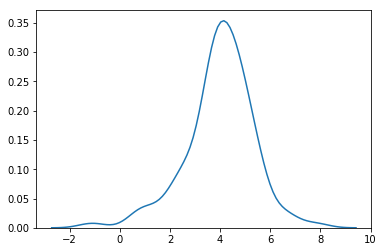

In [25]:
sns.kdeplot(ppc['JAK1']);

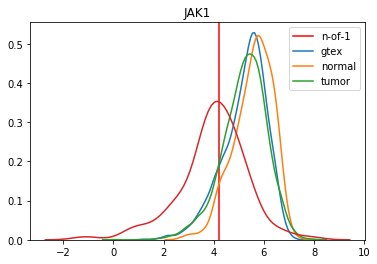

In [27]:
plot_gene_dist(n_of_1, gene='JAK1')
sns.kdeplot(ppc['JAK1']);

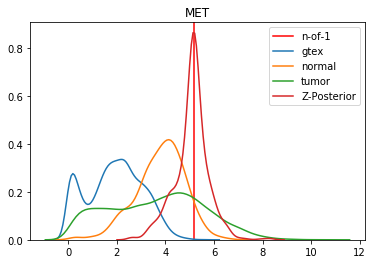

In [62]:
plot_gene_dist(n_of_1, gene='MET')
sns.kdeplot(trace['Z-MET'], label='Z-Posterior')

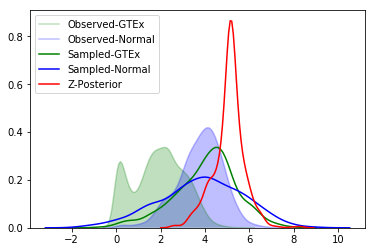

In [68]:
sns.kdeplot(gtex['MET'], label='Observed-GTEx', shade=True, alpha=0.25, color='green')
sns.kdeplot(normal['MET'], label='Observed-Normal', shade=True, alpha=0.25, color='blue')
sns.kdeplot(trace['Y-MET-gtex'], label='Sampled-GTEx', color='green')
sns.kdeplot(trace['Y-MET-normal'], label='Sampled-Normal', color='blue')
sns.kdeplot(trace['Z-MET'], label='Z-Posterior', color='red')

In [ ]:
sns.kdeplot(gtex['MET'], label='Observed', shade=True, alpha=0.25)
sns.kdeplot(trace['Y-MET-gtex'], label='Sampled')
plt.title('GTEx - MET gene')

Try extracting beta and alpha and plugging those in

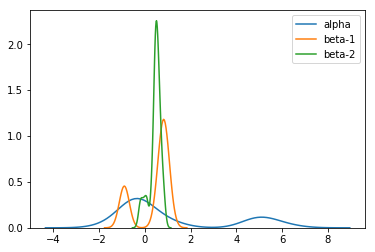

In [74]:
#plt.axvline(np.median(trace['alpha']))
sns.kdeplot(trace['alpha'], label='alpha')
sns.kdeplot(trace['beta'][:,0], label='beta-1')
sns.kdeplot(trace['beta'][:,1], label='beta-2')

In [76]:
ppc = pm.sample_ppc(trace, model=model)

100%|██████████| 200/200 [00:06<00:00, 28.58it/s]


In [ ]:
ppc['Z_obs-']

In [77]:
ppc.keys()

dict_keys(['X-GRASP-gtex', 'X-GRASP-normal', 'X-SP3-gtex', 'X-SP3-normal', 'X-RP11-529K1.2-gtex', 'X-RP11-529K1.2-normal', 'X-HSD17B3-gtex', 'X-HSD17B3-normal', 'X-RP11-79P5.10-gtex', 'X-RP11-79P5.10-normal', 'Z_obs-GRASP', 'Z_obs-SP3', 'Z_obs-RP11-529K1.2', 'Z_obs-HSD17B3', 'Z_obs-RP11-79P5.10'])

## N-Genes

### 5 Genes

In [89]:
genes = np.random.choice(df.columns[5:], size=5)
model, trace = train_model(n_of_1, genes, datasets)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [Z-TATDN2P2, Z-ATXN7L2, Z-NOXO1, Z-MYB-AS1, Z-GPR89A, sigma, beta, alpha, Y-TATDN2P2-normal, Y-TATDN2P2-gtex, Y-ATXN7L2-normal, Y-ATXN7L2-gtex, Y-NOXO1-normal, Y-NOXO1-gtex, Y-MYB-AS1-normal, Y-MYB-AS1-gtex, Y-GPR89A-normal, Y-GPR89A-gtex, hyper_sigma, hyper_mu]
Sampling 12 chains: 100%|██████████| 14400/14400 [08:00<00:00,  2.38draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 diver

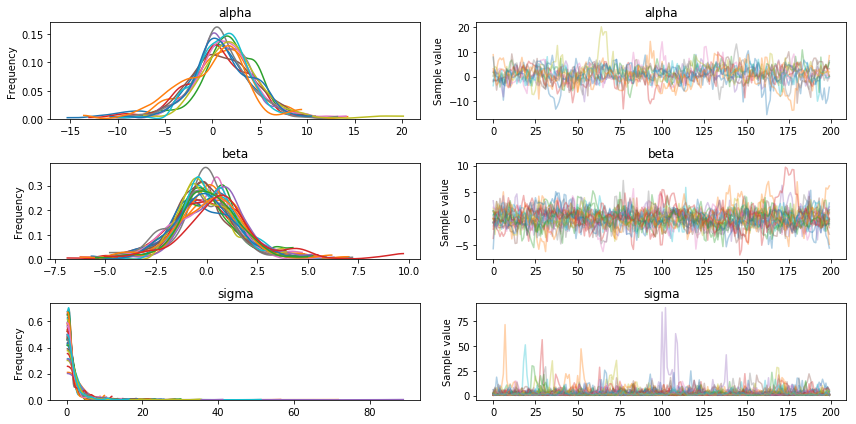

In [90]:
pm.traceplot(trace, varnames=['alpha', 'beta', 'sigma']);

In [91]:
genes

array(['GPR89A', 'MYB-AS1', 'NOXO1', 'ATXN7L2', 'TATDN2P2'], dtype=object)

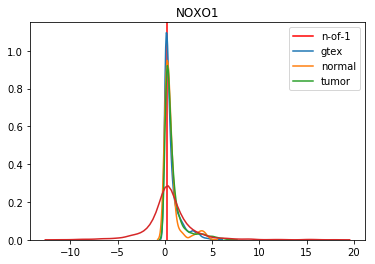

In [106]:
plot_gene_dist(n_of_1, 'NOXO1')
sns.kdeplot(trace['Z-NOXO1'])